In [44]:
%matplotlib inline
import torch
import random
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns

# hyperparameters turning
from ray import tune, train, ray
from ray.tune.schedulers import ASHAScheduler

#Plotting 
from pandas.plotting import scatter_matrix

#Libraries for Statistical Models
import statsmodels.api as sm

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

_TARGET_STK = 'NVDA'
pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False
pd.options.display.float_format = '{:.3f}'.format

torch.seed = 42
random.seed(42)


In [ ]:
ray.init(log_to_driver=False)

In [2]:
def get_filename_of_ipynb():
    from IPython import get_ipython
    import os
    ip = get_ipython()
    path = ''
    if '__vsc_ipynb_file__' in ip.user_ns:
        path = ip.user_ns['__vsc_ipynb_file__']

    return '.'.join(os.path.basename(path).split('.')[:-1])

In [3]:
from datetime import datetime
import yfinance as yfin

# Loading the data
stk_tickers = [_TARGET_STK]
idx_tickers = ['VIXCLS']

start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)
# stk_data = web.get_data_yahoo(stk_tickers, start, end)
stk_data = yfin.download(stk_tickers, start, end).dropna()
idx_data = web.DataReader(idx_tickers, 'fred', start, end).dropna()

print(stk_data)
print(idx_data)

[*********************100%%**********************]  1 of 1 completed
              Open    High     Low   Close  Adj Close    Volume
Date                                                           
2014-01-02   3.980   3.995   3.930   3.965      3.741  26009200
2014-01-03   3.973   3.980   3.905   3.918      3.696  25933200
2014-01-06   3.957   4.000   3.920   3.970      3.745  40949200
2014-01-07   4.010   4.050   3.983   4.035      3.807  33328800
2014-01-08   4.050   4.110   4.035   4.090      3.859  30819200
...            ...     ...     ...     ...        ...       ...
2023-12-22 491.950 493.830 484.670 488.300    488.300  25213900
2023-12-26 489.680 496.000 489.600 492.790    492.790  24420000
2023-12-27 495.110 496.800 490.850 494.170    494.170  23364800
2023-12-28 496.430 498.840 494.120 495.220    495.220  24658700
2023-12-29 498.130 499.970 487.510 495.220    495.220  38869000

[2516 rows x 6 columns]
            VIXCLS
DATE              
2014-01-02  14.230
2014-01-03  13.76

In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
validation_size = 0.2
epoch_num = 300
batch_size = 32
log_dir = f'runs/{get_filename_of_ipynb()}_{_TARGET_STK}'
print(log_dir)

runs/BuySellSignalPrediction_NVDA


In [95]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn_pandas import DataFrameMapper
import pandas_ta as ta

def gen_analysis_data(stock_name):
    data = pd.concat([
        stk_data.ta.adosc(),
        stk_data.ta.kvo(),
        stk_data.ta.rsi(close='Adj Close', length=10)/100,
        stk_data.ta.rsi(close='Adj Close', length=30)/100,
        stk_data.ta.rsi(close='Adj Close', length=200)/100,
        stk_data.ta.stoch(k=10)/100,
        stk_data.ta.stoch(k=30)/100,
        stk_data.ta.stoch(k=200)/100,
        stk_data.ta.sma(close='Adj Close', length=10).astype('float32'),
        stk_data.ta.sma(close='Adj Close', length=60).astype('float32'),
        ], 
        axis=1)
    data = data.dropna().astype('float32')
    return data


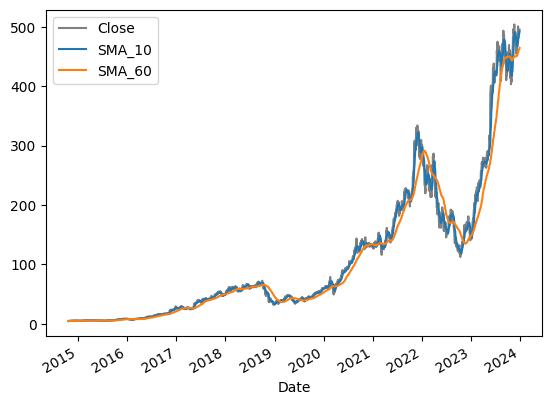

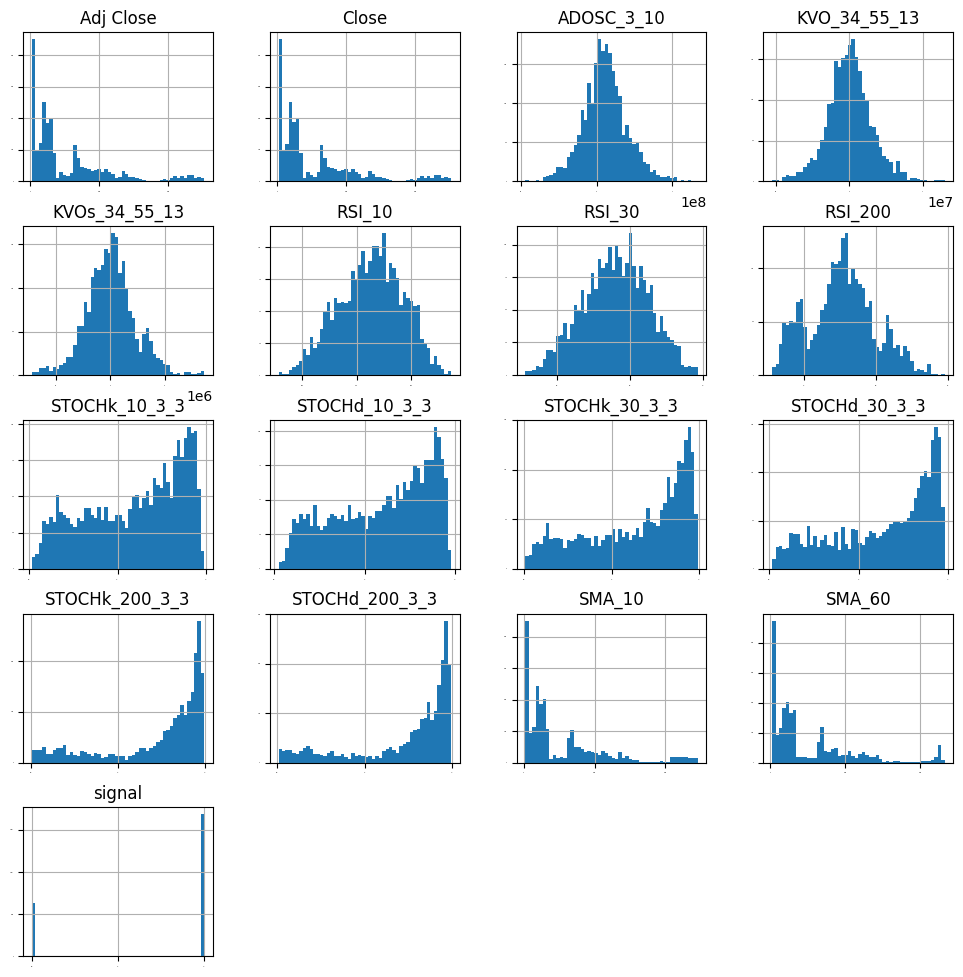

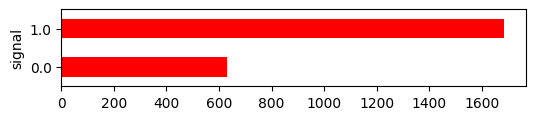

In [32]:
pyplot.figure()
dataset['Close'].plot(color='grey')
dataset['SMA_10'].plot()
dataset['SMA_60'].plot()
pyplot.legend()
pyplot.show()

dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red', figsize=(6, 1))
pyplot.show()

<Axes: >

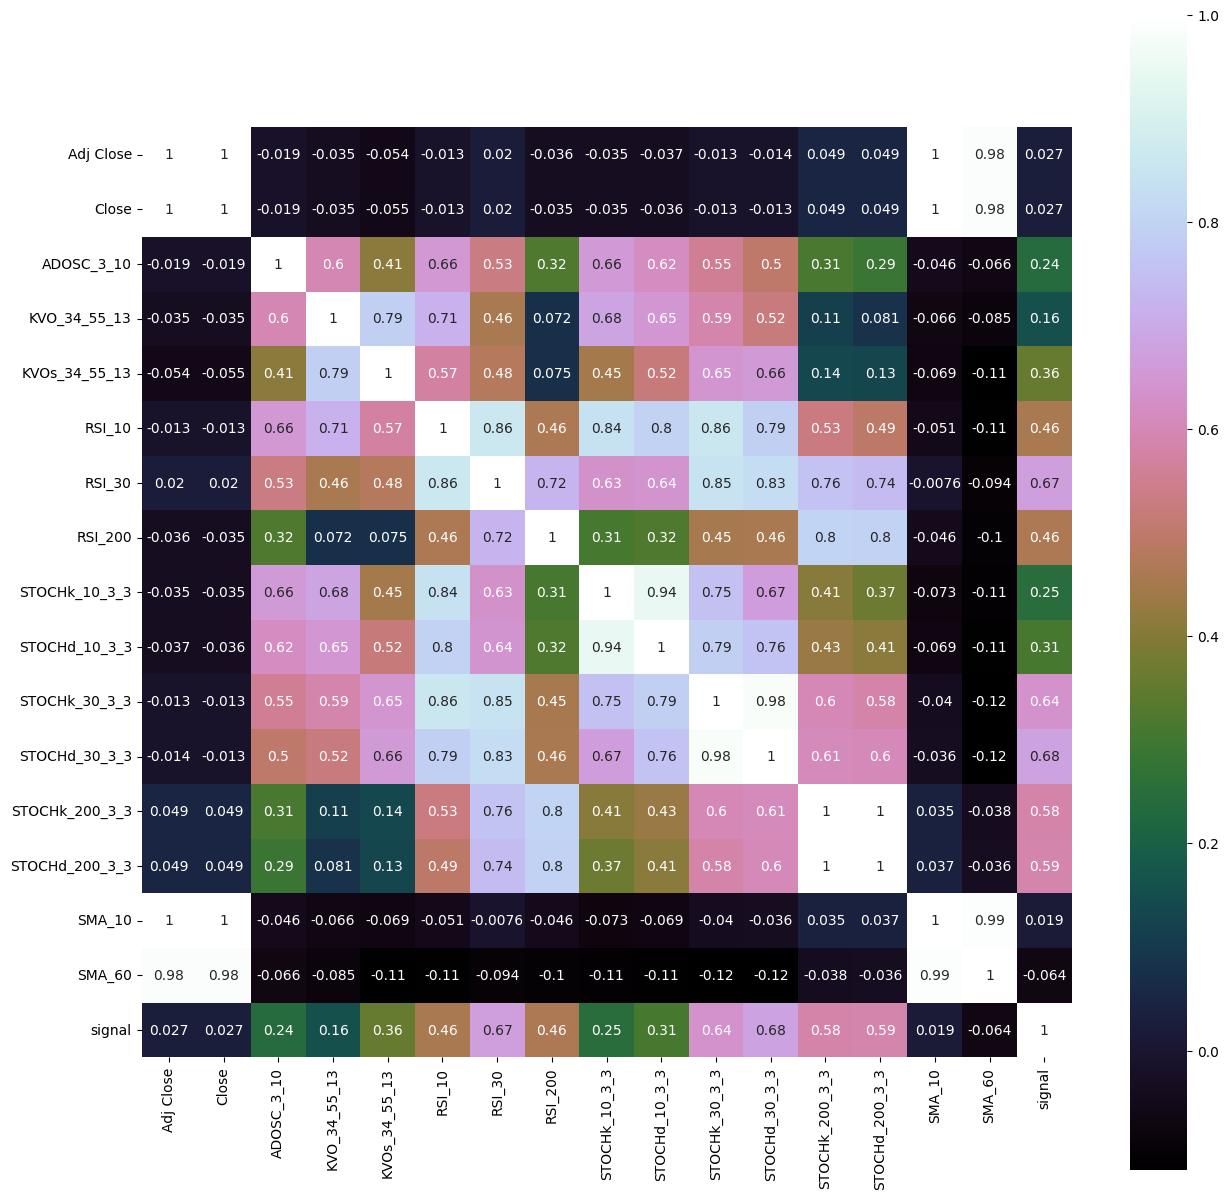

In [33]:
correlation = dataset.corr()
pyplot.figure(figsize=(15, 15))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

In [171]:
import random
import math
from torch.utils.data import Dataset, DataLoader

class SignalDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return (torch.tensor(np.array(self.X.iloc[idx, :]), dtype=torch.float32),
                torch.tensor(np.array(self.Y.iloc[idx, :]), dtype=torch.float32))


def prepare_dataloader():
    dataset = gen_analysis_data(_TARGET_STK)
    buy_signal = (dataset['SMA_10'] > dataset['SMA_60'])
    dataset['BUY'] = (buy_signal).astype('float32')
    dataset['SELL'] = (~buy_signal).astype('float32')
    # print(dataset.head(10))

    test_size = int(len(dataset) * validation_size)
    random.seed(42)
    test_data_idx = sorted(random.sample(range(0, len(dataset)), test_size))
    test_data = dataset.iloc[test_data_idx]
    train_data = dataset.drop(index=test_data.index)

    X_train_data = train_data.iloc[:,:-4]
    Y_train_data = train_data.iloc[:, -2:]
    print(X_train_data.head(10))
    print(Y_train_data.head(10))

    X_test_data = test_data.iloc[:,:-4]
    Y_test_data = test_data.iloc[:, -2:]
    print(X_test_data.head(10))
    print(Y_test_data.head(10))

    train_loader = DataLoader(SignalDataset(X_train_data, Y_train_data), batch_size, shuffle=True)
    test_loader = DataLoader(SignalDataset(X_test_data, Y_test_data), batch_size)

    return train_loader, test_loader

# X_train_data = dataset.drop(index=X_test_data.index)

# Y_train_data = X_train_data[[]].copy()
# Y_train_data['BUY'] = (buy_signal).astype('float32')
# Y_train_data['SELL'] = (~buy_signal).astype('float32')

# buy_signal = (X_test_data['SMA_10'] > X_test_data['SMA_60'])
# Y_test_data = X_test_data[[]].copy()
# Y_test_data['BUY'] = (buy_signal).astype('float32')
# Y_test_data['SELL'] = (~buy_signal).astype('float32')




              ADOSC_3_10  KVO_34_55_13  KVOs_34_55_13  RSI_10  RSI_30  RSI_200  STOCHk_10_3_3  STOCHd_10_3_3  STOCHk_30_3_3  STOCHd_30_3_3  STOCHk_200_3_3  STOCHd_200_3_3
Date                                                                                                                                                                      
2014-10-22 -13501420.000     -6112.057   -1276033.250   0.495   0.462    0.527          0.732          0.594          0.399          0.318           0.540           0.498
2014-10-23 -10554884.000    532812.875   -1017626.688   0.564   0.493    0.532          0.870          0.742          0.496          0.409           0.589           0.545
2014-10-27  -2003236.375    685216.562    -525782.562   0.595   0.507    0.534          0.935          0.887          0.599          0.540           0.642           0.611
2014-10-28   5727250.000   1109885.625    -292115.656   0.660   0.538    0.539          0.958          0.916          0.678          0.601       

In [35]:
from torch import nn
class BuySellSignalClassifier(nn.Module):
    def __init__(self, input_size, num_layers, activation_type):
        super.__init__()
        self.input_size = input_size
        
        layers = []
        in_features = input_size
        for i in range(1, num_layers):
            out_features = int(in_features / 2)
            if (out_features <= 2):
                break
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU() if activation_type == 1 else
                          nn.Sigmoid()) if activation_type == 2 else nn.Tanh()
            in_features = out_features
        layers.append(nn.Linear(in_features, 2))
        self.classifier = nn.Sequential(*layers)
        self.soft_max = nn.LogSoftMax(dim=1)

    def forward(self, x):
        output = self.classifier(x)
        output = self.soft_max(output)
        return output
    
def save_model(model, hyper_parameters, file_path, epoch_num=None):
    state = {
        'epoch_num': epoch_num,
        'time': str(datetime.now),
        'model_state': model.state_dict(),
        'input_size': model.input_size,
        'hyper_parameters': hyper_parameters
    }
    torch.save(state, file_path)

def load_model(file_path):
    data_dict = torch.load(file_path)
    hyper_parameters = data_dict['hyper_parameters']
    model = BuySellSignalClassifier(
        data_dict['input_size'],
        num_layers=hyper_parameters['num_layers'],
        activation_type=hyper_parameters['activation_type'])
    model.load_state_dict(data_dict['model_state'])
    return model, hyper_parameters


In [17]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings('ignore')

def do_train(model, optimizer, train_dl, test_dl, id_str, writer):
    criterion = torch.nn.MSELoss()

    model_name = f"{log_dir}/{id_str}.pt"
    best_loss = 999999999    
    total_loss = 0.0
    total_vloss = 0.0
    for epoch in tqdm(range(epoch_num)):
        model.train()
        running_loss = 0.0
        
        for i, (x, y) in enumerate(train_dl):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model.state_dict(), model_name)

        with torch.no_grad():
            (testScore, test_y_gt, test_y_pred, running_vloss)  = eval_dl_method(model, test_dl, criterion)
            train.report({"mse_score":testScore})
            
        writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : running_loss / len(train_dl), 'Validation' : running_vloss / len(test_dl) },
                            epoch + 1)
        total_loss += running_loss / len(train_dl)
        total_vloss += running_vloss / len(test_dl)

        writer.flush()
        
    return {'Train loss':total_loss/epoch_num, 'Validation loss': total_vloss/epoch_num}

def train_LSTM(config):
    return_period = 5 #config["return_period"]
    seq_len = 5 #config["seq_len"]
    lr = 0.01 #config["lr"]
    momentum = config["momentum"]
    optim_type = config["optim_type"]
    num_layers = config["num_layers"]
    hidden_size = config["hidden_size"]
    num_fc_layers = config["num_fc_layers"]
    activation_type = config["activation_type"]

    id_str = f"{return_period}_{seq_len}_{lr}_{momentum}_{optim_type}_{num_layers}_{hidden_size}_{num_fc_layers}_{activation_type}"

    writer = SummaryWriter(f"{log_dir}/{id_str}")    

    train_loader, test_loader, features = prepare_dataloader(return_period, seq_len)
    model = StockPricePredictionLSTM(seq_len, input_size=len(features),
                                     hidden_size=hidden_size,num_layers=num_layers,
                                     num_fc_layers=num_fc_layers, activation_type=activation_type)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) if optim_type == 1 else torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    metric_dict = do_train(model, optimizer, train_loader, test_loader, id_str, writer)
    writer.add_hparams(
        {
            "return_period": return_period,
            "seq_len": seq_len,
            "lr": lr,
            "momentum": momentum,
            "optim_type": optim_type,
            "num_layers": num_layers,
            "hidden_size": hidden_size,
            "num_fc_layers": num_fc_layers,
            "activation_type": activation_type
        },
        metric_dict
    )
    writer.close()


In [ ]:
time_str = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
log_dir = f'/mnt/AIWorkSpace/work/fin-ml/runs/{_TARGET_STK}/{time_str}'
config={
    "return_period":2,
    "seq_len":2,
    "lr":0.1,
    "momentum":0.4100411732392869,
    "optim_type":2,
    "num_layers":1,
    "hidden_size":128,
    "num_fc_layers":2,
    "activation_type":1
}
train_LSTM(config)

In [18]:
import warnings
warnings.filterwarnings('ignore', category=Warning)
warnings.filterwarnings('ignore', module='TF-TRT')
warnings.filterwarnings('ignore', module='tensorflow')
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=SyntaxWarning)
warnings.filterwarnings('ignore', category=PendingDeprecationWarning)
warnings.filterwarnings('ignore', category=ImportWarning)
warnings.filterwarnings('ignore', category=UnicodeWarning)
warnings.filterwarnings('ignore', category=BytesWarning)
warnings.filterwarnings('ignore', category=ResourceWarning)
warnings.simplefilter("always")


search_space = {
    # "return_period": tune.grid_search([2,3,5,10]),
    # "seq_len": tune.grid_search([2,3,4,5]),
    # "lr": tune.grid_search([0.001, 0.01, 0.1]),
    "momentum": tune.uniform(0.1, 0.9),
    "optim_type": tune.grid_search([1, 2]),
    "num_layers": tune.grid_search([1, 2, 4, 8]),
    "hidden_size": tune.grid_search([8, 16, 32, 64, 128]),
    "num_fc_layers": tune.grid_search([1, 2, 3]),
    "activation_type": tune.grid_search([1, 2, 3])
}

time_str = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
log_dir = f'/mnt/AIWorkSpace/work/fin-ml/runs/{_TARGET_STK}/{time_str}'

analysis = tune.run(train_LSTM, 
                    config=search_space,
                    resources_per_trial={'cpu':0.1, 'gpu':0.1},
                    metric="mse_score",
                    mode="min")

2024-01-19 21:52:54,351	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-01-19 21:52:54,363	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,mse_score
train_LSTM_278d2_00000,0.0499599
train_LSTM_278d2_00001,0.0564039
train_LSTM_278d2_00002,0.0480619
train_LSTM_278d2_00003,0.0607098
train_LSTM_278d2_00004,0.0620129
train_LSTM_278d2_00005,0.0699729
train_LSTM_278d2_00006,0.0564917
train_LSTM_278d2_00007,0.0603667
train_LSTM_278d2_00008,0.0601814
train_LSTM_278d2_00009,0.0545767


2024-01-20 01:00:07,849	INFO tune.py:1042 -- Total run time: 11233.50 seconds (11233.44 seconds for the tuning loop).


In [19]:
mse_list = []
trial_list = list(analysis.trial_dataframes.values())
for i, trial in enumerate(trial_list):
    if trial.empty == False:
        d = pd.DataFrame.from_dict({"mse_score": trial.describe().loc['mean', 'mse_score'], "trial_id": trial.loc[0:0,'trial_id'] })
    else:
        d = pd.DataFrame.from_dict({"mse_score": [np.NaN], "trial_id": [np.NaN]})
    mse_list.append(d)
mse_df = pd.concat(mse_list)
mse_df = mse_df.reset_index().loc[:, ["mse_score", "trial_id"]]
print(mse_df)


     mse_score     trial_id
0     0.047597  278d2_00000
1     0.051936  278d2_00001
2     0.053743  278d2_00002
3     0.052701  278d2_00003
4     0.053960  278d2_00004
..         ...          ...
355   0.039063  278d2_00355
356   0.039645  278d2_00356
357   0.046811  278d2_00357
358   0.039301  278d2_00358
359   0.059767  278d2_00359

[360 rows x 2 columns]


In [29]:
config_df = pd.DataFrame(analysis.get_all_configs().values())
print(config_df)

results = pd.concat([mse_df, config_df], axis=1)
print(results)

sorted_results = results.sort_values(by="mse_score")
print(sorted_results.head(100))
sorted_results_file = f"{time_str}_sorted_results.csv"
sorted_results.to_csv(sorted_results_file)

best_config = config_df.iloc[sorted_results.index[0]]
print(best_config)

     momentum  optim_type  num_layers  hidden_size  num_fc_layers  activation_type
0     0.49678           1           1            8              1                1
1     0.69578           1           1            8              1                2
2     0.71175           1           1            8              1                3
3     0.58273           1           1           16              1                1
4     0.48747           1           1           16              1                2
..        ...         ...         ...          ...            ...              ...
355   0.49438           2           8           64              3                2
356   0.49899           2           8           64              3                3
357   0.21838           2           8          128              3                1
358   0.70031           2           8          128              3                2
359   0.15960           2           8          128              3                3

[36

In [31]:
id_str_of_best = f"5_5_0.01_{best_config.momentum}_{int(best_config.optim_type)}_{int(best_config.num_layers)}_{int(best_config.hidden_size)}_{int(best_config.num_fc_layers)}_{int(best_config.activation_type)}"
best_model_name = f"{log_dir}/{id_str_of_best}.pt"
print(best_model_name)

/mnt/AIWorkSpace/work/fin-ml/runs/MSFT/2024-01-19_21.52.54/5_5_0.01_0.15544857677627022_2_2_128_1_1.pt


In [33]:
sorted_results = pd.read_csv(sorted_results_file, dtype='str')
best_config = sorted_results.loc[0]

id_str_of_best = f"5_5_0.01_{best_config.momentum}_{best_config.optim_type}_{best_config.num_layers}_{best_config.hidden_size}_{best_config.num_fc_layers}_{best_config.activation_type}"
best_model_name = f"/mnt/AIWorkSpace/work/fin-ml/runs/{_TARGET_STK}/{time_str}/{id_str_of_best}.pt"
print(best_model_name)

/mnt/AIWorkSpace/work/fin-ml/runs/MSFT/2024-01-19_21.52.54/5_5_0.01_0.15544857677627022_2_2_128_1_1.pt


In [34]:
import math 
from sklearn.metrics import mean_squared_error

pd.set_option('display.precision', 5)

return_period = 5
seq_len = 5
train_loader, test_loader, features = prepare_dataloader(return_period, seq_len)

model = StockPricePredictionLSTM(seq_len, input_size=len(features),
                                     hidden_size=int(best_config.hidden_size),num_layers=int(best_config.num_layers),
                                     num_fc_layers=int(best_config.num_fc_layers), activation_type=int(best_config.activation_type))

model.load_state_dict(torch.load(best_model_name))
model.to(device)
model.eval()

(trainScore, train_y_gt, train_y_pred, _)= eval_dl_method(model, train_loader, device=device)
(testScore, test_y_gt, test_y_pred, _)  = eval_dl_method(model, test_loader, device=device)
print(test_y_pred)
print(f"Train RMSE: {trainScore:.2f}\nTest RMSE: {testScore:.2f}")


[-0.01913168, -0.019504327, -0.011383627, -0.0018858279, 0.0065648886, 0.013105243, 0.0154249035, 0.0142230205, 0.009373609, 0.016051397, 0.015376259, 0.019547615, 0.021208778, 0.018554017, 0.014335179, 0.0066048815, 0.0017346644, -0.0019805694, 0.0017169917, 0.0046631186, 0.008506959, 0.008576211, 0.0076857167, 0.00676595, 0.005709655, 0.007099658, 0.0070419717, 0.01186125, 0.010594994, -0.0015245436, -0.01708326, -0.019816663, -0.02356705, -0.014966112, -0.0031675848, 0.010282513, 0.017187852, 0.015281171, 0.014310181, 0.0072756666, 0.0021835712, -0.003127877, -0.0011100324, -0.00039109617, -0.0007595721, -0.0015480036, -0.0010318349, -0.00012999616, -0.000624711, 0.0007201654, 0.00023460732, -0.0006976056, -0.0031614641, 0.0009568517, 0.0018576344, 0.0050204205, 0.0057956944, 0.004854675, -0.0008689764, -0.002084032, -0.002251888, 0.00074620143, -0.0012283886, -0.0025973732, -0.0042590615, -0.011051614, -0.014402155, -0.012495797, -0.0075592515, -0.0022902715, 0.016931176, 0.0232491

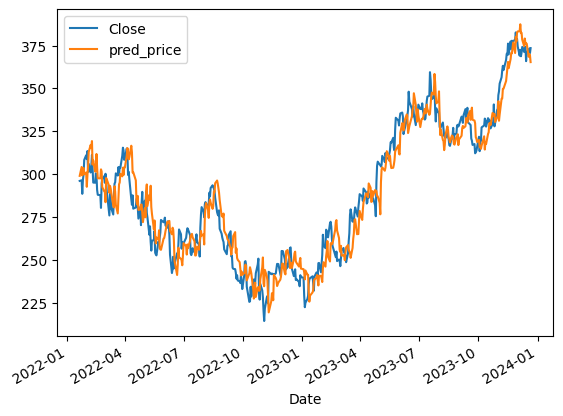

In [35]:
target_raw = stk_data.loc[test_loader.dataset.X.index.values].xs(_TARGET_STK, axis=1, level=1)
# print(target_raw)
target_raw = target_raw.drop(target_raw.index[range(seq_len - 1)], axis=0)

test_y_pred_df = pd.DataFrame(index=target_raw.index.copy())
test_y_pred_df['pred_price'] = test_y_pred
test_y_pred_df['pred_price'] = (test_y_pred_df['pred_price'] + 1) * target_raw['Close']
test_y_pred_df = test_y_pred_df.shift(return_period)
tmp_data = pd.concat([target_raw, test_y_pred_df], axis=1).dropna()

tmp_data['Close'].plot()
tmp_data['pred_price'].plot()
pyplot.legend()
pyplot.show()
